In [1]:
import rlssm
import pandas as pd
import os

/Users/Khamir/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Import the grouped data

In [2]:
par_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(par_path, 'data/data_experiment.csv')

data = pd.read_csv(data_path, index_col=0)

data = data[data.participant < 5].reset_index(drop=True)

data['block_label'] += 1

data.head()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy
0,1,1.0,1.0,43.0,39.0,2,1,1.0,1.244082,0.0
1,1,1.0,2.0,60.0,50.0,4,3,1.0,1.101821,1.0
2,1,1.0,3.0,44.0,36.0,4,2,2.0,1.029923,0.0
3,1,1.0,4.0,55.0,55.0,4,3,2.5,1.368007,0.0
4,1,1.0,5.0,52.0,49.0,4,3,3.5,1.039329,1.0


#### Initialise the model

In [3]:
model = rlssm.RLModel_2A(hierarchical_levels = 2, increasing_sensitivity=True, separate_learning_rates=True)

Using cached StanModel


In [4]:
model.family, model.model_label, model.hierarchical_levels

('RL_2A', 'hierRL_2A_pow_2lr', 2)

In [5]:
model.increasing_sensitivity, model.separate_learning_rates

(True, True)

#### Fit

In [6]:
# sampling parameters
n_iter = 1000
n_chains = 2
n_thin = 1

# learning parameters
K = 4 # n options
initial_value_learning = 27.5 # intitial value (Q0)

# bayesian model
alpha_pos_priors = {'mu_mu':0, 'sd_mu':.8, 'mu_sd':0, 'sd_sd':.5}

In [7]:
# User-Supplied Initial Values:
n_participants = len(data.participant.unique())

def starting_values(chain_id, n_participants=n_participants):
    import numpy as np
    from scipy import stats
    
    out = {
        'mu_alpha_pos': stats.norm.ppf(.1),
        'mu_alpha_neg': stats.norm.ppf(.1),
        'mu_consistency': np.log(.5),
        'mu_scaling': 5,
    
        'sd_alpha_pos':.1,
        'sd_alpha_neg':.1,
        'sd_consistency':.1,
        'sd_scaling':.1,
    
        'z_alpha_pos':list(np.random.normal(0, 1, n_participants)),
        'z_alpha_neg':list(np.random.normal(0, 1, n_participants)),
        'z_consistency':list(np.random.normal(0, 1, n_participants)),
        'z_scaling':list(np.random.normal(0, 1, n_participants))
    }
    
    return out

In [9]:
model_fit = model.fit(
    data, 
    K, 
    initial_value_learning,
    alpha_pos_priors = alpha_pos_priors,
    thin = n_thin,
    iter = n_iter,
    chains = n_chains)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Checks MCMC diagnostics:
n_eff / iter looks reasonable for all parameters
814.0 of 1000 iterations ended with a divergence (81.4%)
  Try running with larger adapt_delta to remove the divergences
0 of 1000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


#### get Rhat

In [10]:
model_fit.rhat.describe()

,rhat
count,24.000000
mean,1.015905
std,0.022220
min,0.998962
25%,1.002015
50%,1.007323
75%,1.017522
max,1.081682


In [11]:
model_fit.rhat.head()

,rhat,variable
0,1.073527,mu_alpha_pos
1,1.001434,mu_alpha_neg
2,1.000209,mu_consistency
3,1.017083,mu_scaling
4,1.081682,sd_alpha_pos


#### get wAIC

In [12]:
model_fit.waic

{'lppd': -412.5377916113189,
 'p_waic': 8.770263522293563,
 'waic': 842.6161102672249,
 'waic_se': 34.751672560289}

### Posteriors

In [13]:
model_fit.samples

,chain,draw,transf_mu_alpha_pos,transf_mu_alpha_neg,transf_mu_consistency,transf_mu_scaling,alpha_pos_sbj[1],alpha_pos_sbj[2],alpha_pos_sbj[3],alpha_pos_sbj[4],...,alpha_neg_sbj[3],alpha_neg_sbj[4],consistency_sbj[1],consistency_sbj[2],consistency_sbj[3],consistency_sbj[4],scaling_sbj[1],scaling_sbj[2],scaling_sbj[3],scaling_sbj[4]
0,0,151,0.010641,0.202797,1.807443e-13,19.336160,0.010949,0.004388,0.003359,0.012103,...,0.588475,3.847571e-03,0.000000e+00,2.529846e-02,2.402555e-02,2.215828e-11,10.628908,24.737152,15.638247,21.505756
1,0,341,0.012059,0.164839,1.025047e-07,23.057092,0.012186,0.004007,0.003638,0.019986,...,0.665281,1.325577e-03,1.081659e-10,0.000000e+00,5.653968e-10,6.493245e-09,4.126252,55.297337,26.338080,9.567918
2,0,66,0.009189,0.678871,2.438011e-08,33.554196,0.012800,0.005034,0.003378,0.019490,...,0.609839,6.992230e-04,5.201173e-12,1.316725e-13,0.000000e+00,1.110223e-14,48.164868,24.923084,4.397065,65.910597
3,0,80,0.005871,0.628901,0.000000e+00,38.501985,0.013507,0.005118,0.003066,0.015686,...,0.830924,2.569010e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,23.889429,21.140338,38.929447,42.524500
4,0,426,0.008905,0.351488,0.000000e+00,25.117721,0.011027,0.003010,0.003628,0.015119,...,0.366919,2.771243e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,20.750421,11.455314,8.150572,0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,290,0.022145,0.200028,0.000000e+00,0.000780,0.010388,0.006677,0.002353,0.023682,...,0.832753,3.371890e-03,2.916978e-11,2.287059e-14,0.000000e+00,0.000000e+00,0.000072,0.131995,0.000244,0.000380
996,1,318,0.011784,0.047482,4.088469e-03,69.605617,0.007781,0.007654,0.002492,0.018870,...,0.720370,1.191278e-09,7.386521e-07,3.886821e-01,1.420946e-03,7.649352e-08,88.775460,104.955108,57.534386,78.188621
997,1,168,0.018125,0.131500,3.642930e-11,3.180360,0.013010,0.006467,0.002694,0.025857,...,0.829241,7.436781e-06,7.544122e-08,2.642331e-14,2.753353e-14,2.161174e-08,0.006803,78.812938,42.308060,0.000748
998,1,68,0.017947,0.120837,0.000000e+00,30.495698,0.013074,0.003898,0.003163,0.018252,...,0.605559,2.557298e-04,2.220446e-15,0.000000e+00,0.000000e+00,0.000000e+00,28.318647,30.975493,29.558877,30.742780


In [14]:
model_fit.trial_samples

OrderedDict([('log_p_t',
              array([[-0.69314718, -0.69314718, -0.60440721, ..., -0.0111039 ,
                      -0.29310712, -0.00702939],
                     [-0.69314718, -0.69314718, -0.59492368, ..., -0.00875037,
                      -0.38514937, -0.0023375 ],
                     [-0.69314718, -0.69314718, -0.59025755, ..., -0.01006879,
                      -0.4086564 , -0.0026096 ],
                     ...,
                     [-0.69314718, -0.69314718, -0.58866217, ..., -0.01257145,
                      -0.50380026, -0.00183871],
                     [-0.69314718, -0.69314718, -0.588177  , ..., -0.01128259,
                      -0.4176347 , -0.00306565],
                     [-0.69314718, -0.69314718, -0.6179428 , ..., -0.01231992,
                      -0.40207684, -0.00395019]]))])

In [15]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

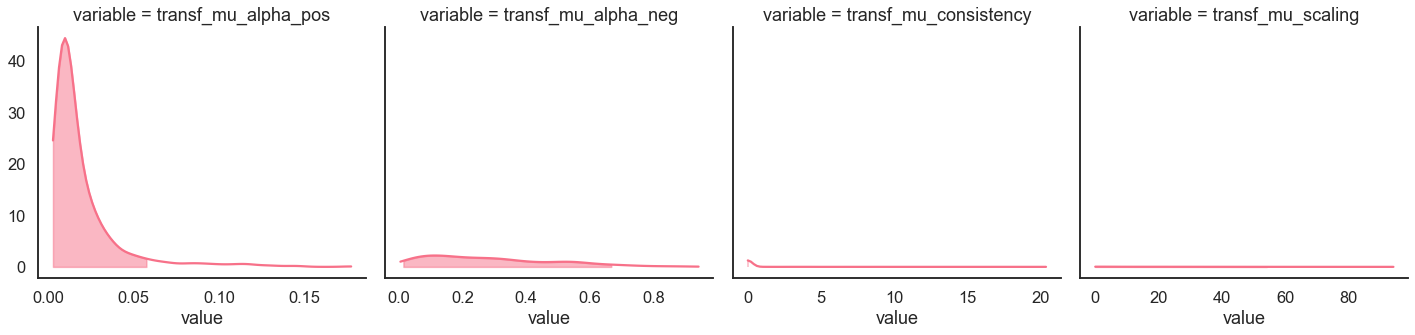

In [16]:
model_fit.plot_posteriors(height=5, show_intervals="HDI", alpha_intervals=.05);

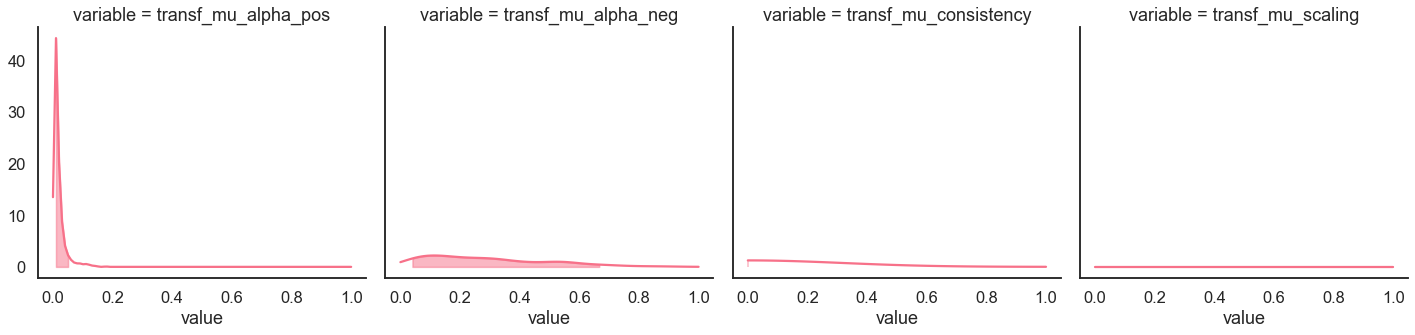

In [17]:
model_fit.plot_posteriors(height=5, show_intervals="BCI", alpha_intervals=.1, clip=(0, 1));

### Posterior predictives

#### Ungrouped

In [18]:
pp = model_fit.get_posterior_predictives_df(n_posterior_predictives=500)

pp

variable accuracy                                      ...                  \
trial         1   2   3   4   5   6   7   8   9   10   ... 949 950 951 952   
sample                                                 ...                   
1               1   1   1   0   1   1   0   0   0   1  ...   1   1   1   1   
2               1   0   1   0   1   1   1   1   1   1  ...   1   1   0   1   
3               0   0   1   0   1   1   1   0   1   0  ...   1   1   0   1   
4               0   0   0   1   0   1   1   0   1   1  ...   1   1   1   1   
5               0   1   1   0   0   1   1   1   1   0  ...   1   1   0   1   
...           ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
496             1   1   0   1   1   0   1   1   1   1  ...   1   1   0   1   
497             1   1   1   0   1   1   1   1   1   0  ...   1   1   1   1   
498             1   0   1   1   1   0   1   1   1   1  ...   1   1   1   1   
499             1   0   0   0   0   0   0   0   0   0  ...   1   1   1   1   
500             1   0   1   0   0   0   0   1   0   1  ...   1   1   0   1   

variable                          
trial    953 954 955 956 957 958  
sample                            
1          0   1   1   1   1   1  
2          1   1   1   1   0   1  
3          0   1   1   1   1   1  
4          0   1   1   1   1   1  
5          1   1   1   1   1   1  
...       ..  ..  ..  ..  ..  ..  
496        0   1   1   1   0   1  
497        1   1   1   1   0   1  
498        1   1   1   1   1   1  
499        1   1   1   1   1   1  
500        1   1   1   1   1   1  

[500 rows x 958 columns]

In [19]:
pp_summary = model_fit.get_posterior_predictives_summary(n_posterior_predictives=500)

pp_summary

,mean_accuracy
sample,
1,0.789144
2,0.798539
3,0.811065
4,0.791232
5,0.772443
...,...
496,0.758873
497,0.792276
498,0.805846


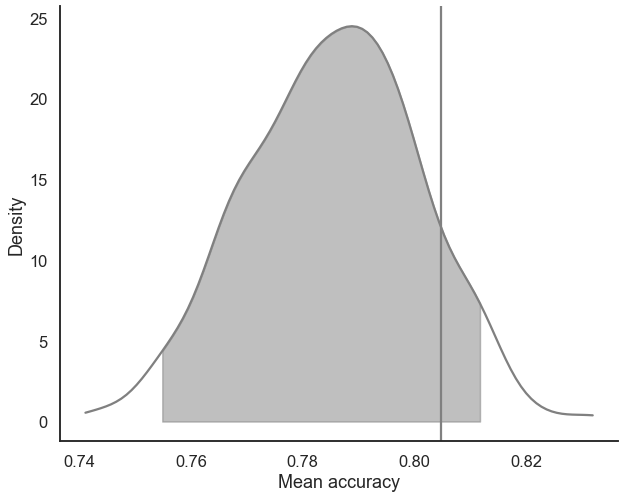

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

model_fit.plot_mean_posterior_predictives(n_posterior_predictives=500, ax=ax, show_intervals='HDI')

ax.set_ylabel('Density')
ax.set_xlabel('Mean accuracy')

sns.despine()

#### Grouped

In [21]:
import numpy as np

data['choice_pair'] = 'AB'
data.loc[(data.cor_option == 3) & (data.inc_option == 1), 'choice_pair'] = 'AC'
data.loc[(data.cor_option == 4) & (data.inc_option == 2), 'choice_pair'] = 'BD'
data.loc[(data.cor_option == 4) & (data.inc_option == 3), 'choice_pair'] = 'CD'

data['block_bins'] = pd.cut(data.trial_block, 8, labels=np.arange(1, 9))

data.head()

,level_0,index,participant,block_label,trial_block,f_cor,f_inc,cor_option,inc_option,times_seen,rt,accuracy,choice_pair,block_bins
0,0,0,1,1.0,1.0,43.0,39.0,2,1,1.0,1.244082,0.0,AB,1
1,1,1,1,1.0,2.0,60.0,50.0,4,3,1.0,1.101821,1.0,CD,1
2,2,2,1,1.0,3.0,44.0,36.0,4,2,2.0,1.029923,0.0,BD,1
3,3,3,1,1.0,4.0,55.0,55.0,4,3,2.5,1.368007,0.0,CD,1
4,4,4,1,1.0,5.0,52.0,49.0,4,3,3.5,1.039329,1.0,CD,1


In [22]:
model_fit.get_grouped_posterior_predictives_summary(grouping_vars=['block_label', 'block_bins', 'choice_pair'], n_posterior_predictives=500)

mean_accuracy
block_label block_bins choice_pair sample               
1.0         1          AB          1                 0.6
                                   2                 0.6
                                   3                 0.2
                                   4                 0.6
                                   5                 0.4
...                                                  ...
3.0         8          CD          496               0.4
                                   497               1.0
                                   498               1.0
                                   499               0.6
                                   500               0.8

[48000 rows x 1 columns]

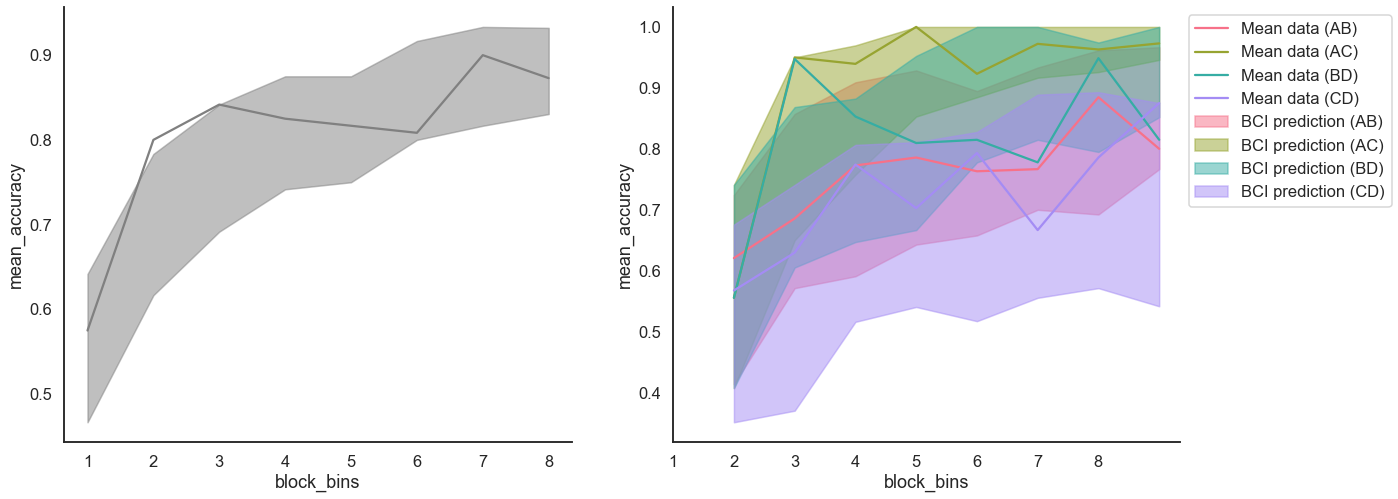

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20,8))

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins'], n_posterior_predictives=500, ax=axes[0])

model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins', 'choice_pair'], n_posterior_predictives=500, ax=axes[1])

sns.despine()

### Get last values for eventual further sampling

In [24]:
sv = model_fit.last_values
sv

,chain,draw,warmup,mu_alpha_neg,mu_alpha_pos,mu_consistency,mu_scaling,sd_alpha_neg,sd_alpha_pos,sd_consistency,...,z_alpha_pos[3],z_alpha_pos[4],z_consistency[1],z_consistency[2],z_consistency[3],z_consistency[4],z_scaling[1],z_scaling[2],z_scaling[3],z_scaling[4]
499,0,499,0,-1.557190,-1.719634,-39.952220,7.610549,1.409172,0.532081,14.519081,...,-1.916148,-0.586565,-0.232832,-0.741959,-0.828419,-0.723340,-1.410976,-0.067900,1.104156,1.376141
999,1,499,0,-0.081763,-2.353104,-9.560325,45.134087,0.857415,0.206819,5.091073,...,-2.318053,1.144838,-1.096003,1.188168,-1.215879,-1.505021,0.870739,1.718529,0.894685,-0.298384
